# Imports and Settings

In [1]:
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n
from scipy.stats import gaussian_kde
from descartes import PolygonPatch
import alphashape
from sklearn.cluster import KMeans
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier
from notebook_functions import *

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

# Configure Variables

In [5]:
data = pd.read_csv("experiment_data/processed/duke_v2.csv")
color_channel_to_use = "YL1"
use_stain_in_AutoGater = True

point_1_that_defines_soa_line=(3.25, 4.5)
point_2_that_defines_soa_line=(4, 6.25)

# Begin Analysis

In [6]:
df = data.loc[data["stain"] == 1]

In [7]:
stain_cols = ["{}-A".format(color_channel_to_use), 
              "{}-H".format(color_channel_to_use),
              "{}-W".format(color_channel_to_use)]
all_features = n.morph_cols + stain_cols

if use_stain_in_AutoGater:
    features = all_features
else:
    features = n.morph_cols
    
print("Features that AutoGater will use: {}".format(features))

Features that AutoGater will use: ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'YL1-A', 'YL1-H', 'YL1-W']


In [8]:
df_with_rfc_labels, X, Y = generate_rf_labels_from_conditions(df, features)

Conditions designated as Live: [{'inducer_concentration': 0.0, 'timepoint': 6.0}]
Conditions designated as Dead: [{'inducer_concentration': 20.0, 'timepoint': 6.0}, {'inducer_concentration': 80.0, 'timepoint': 6.0}]


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 13:18:21
Starting Classification training...
Training time was: 15.33 seconds
Testing time was: 1.07 seconds
Prediction time of untested data was: 15.779917240142822
Run finished at 13:18:58. Total run time = 36.74 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^





Model Boosting took 304.84724617004395 seconds
Training Accuracy = 90.6%
Counter({1: 473277, 0: 329206})
Instructions for updating:
Please use `model.predict()` instead.


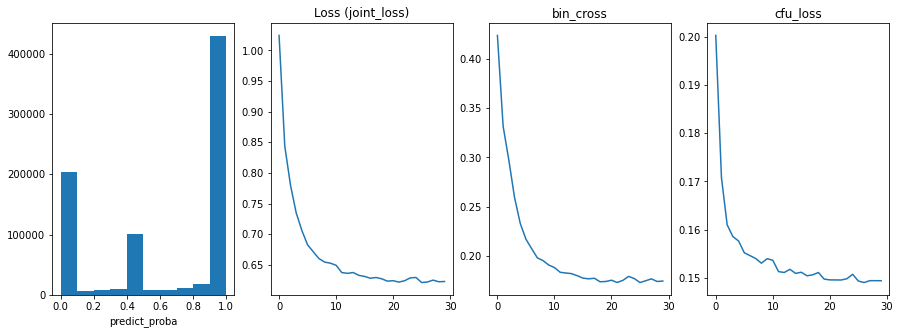

In [9]:
condition_results, preds_and_labels = run_model(model_function=booster_model_v2, lr=0.001,
                                                loss = joint_loss_wrapper(3), 
                                                metrics = [bin_cross, cfu_loss],
                                                X = X, Y = Y, epochs = 30, batch_size = 2048,
                                                verbose = False, shuffle = True, plot_type="line")

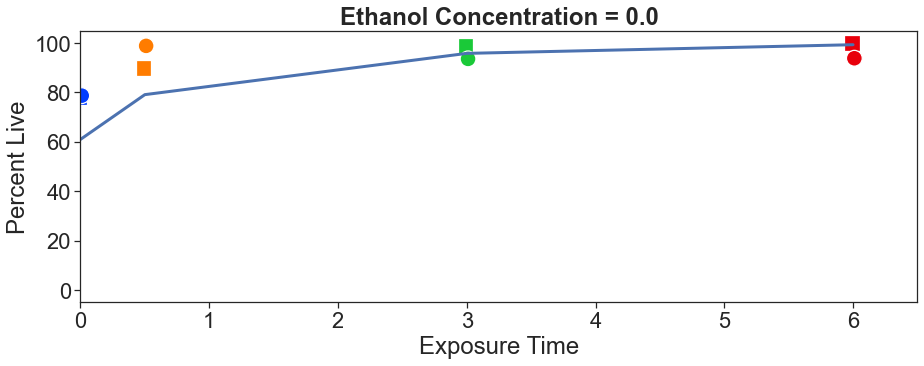

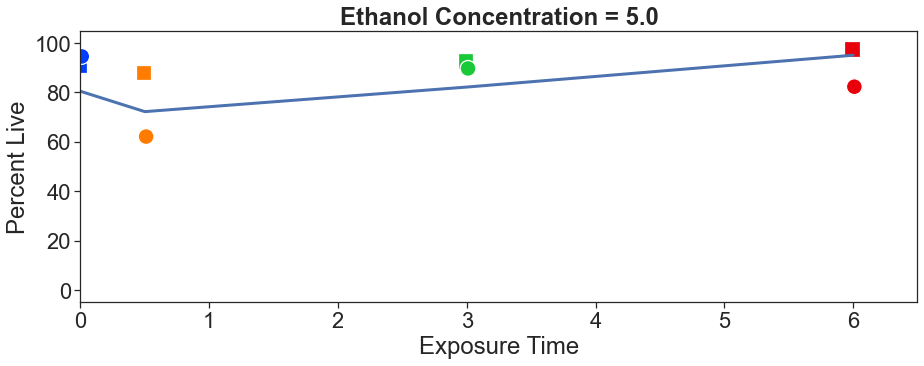

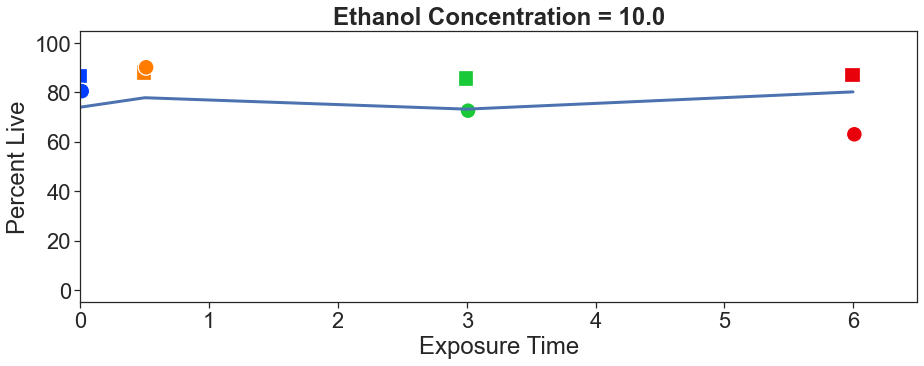

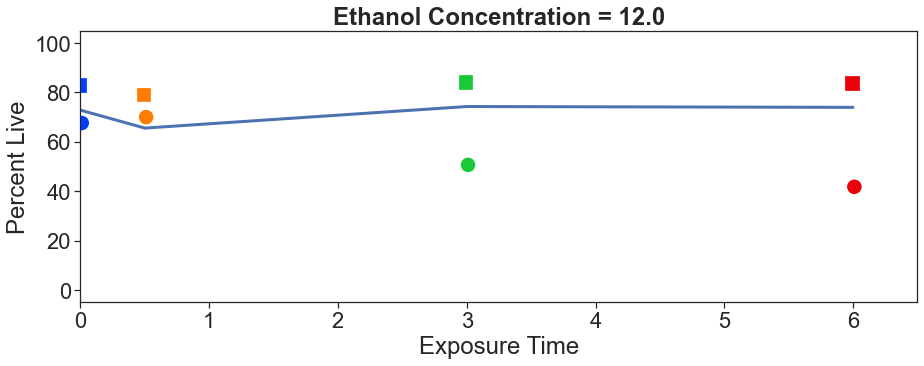

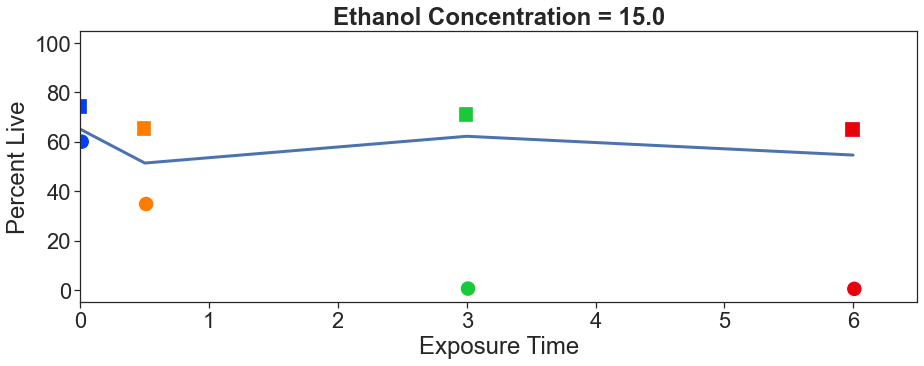

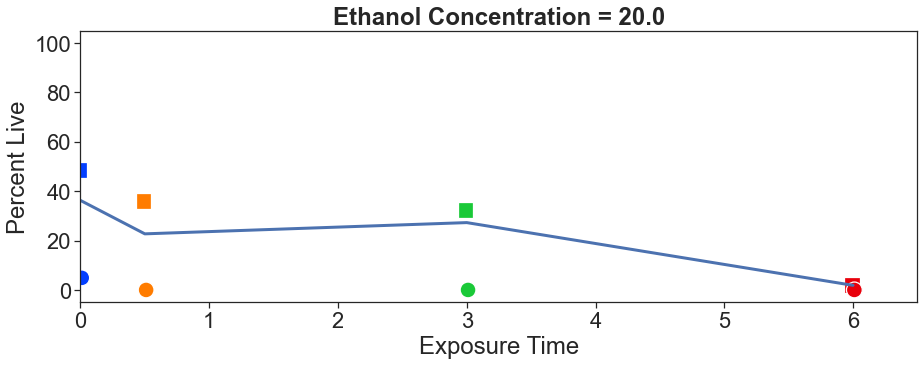

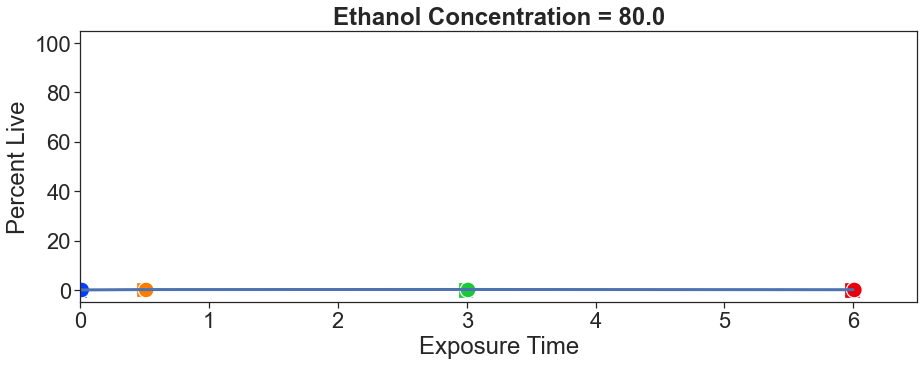

In [10]:
plot_per_cond(condition_results)

In [11]:
if use_stain_in_AutoGater:
    run_info = get_all_run_info(df_with_rfc_labels, X, preds_and_labels)
else:
    run_info = get_all_run_info(df_with_rfc_labels, X, preds_and_labels,
                                append_df_cols=stain_cols)

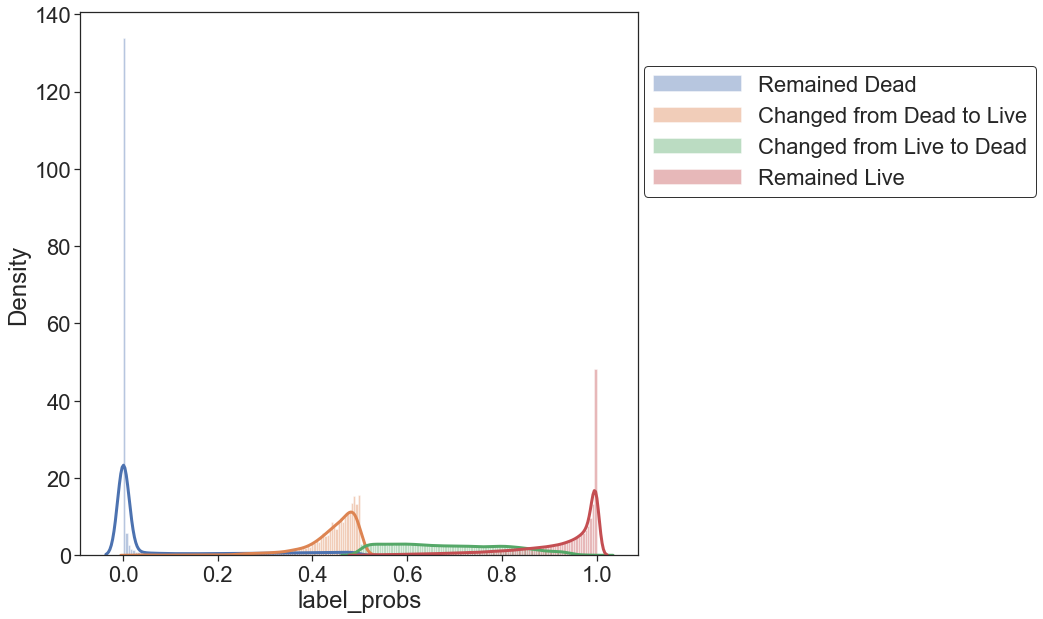

In [12]:
plot_prob_changes(run_info, None)

In [13]:
kde_df = get_conc_df_with_kde_values(run_info,
                                     conc="all",
                                     features=all_features,
                                     cc="{}-H".format(color_channel_to_use))

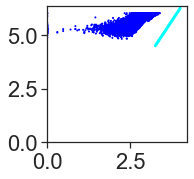

Percent of AutoGater live predictions that are left of the SOA dashed line: 100.0


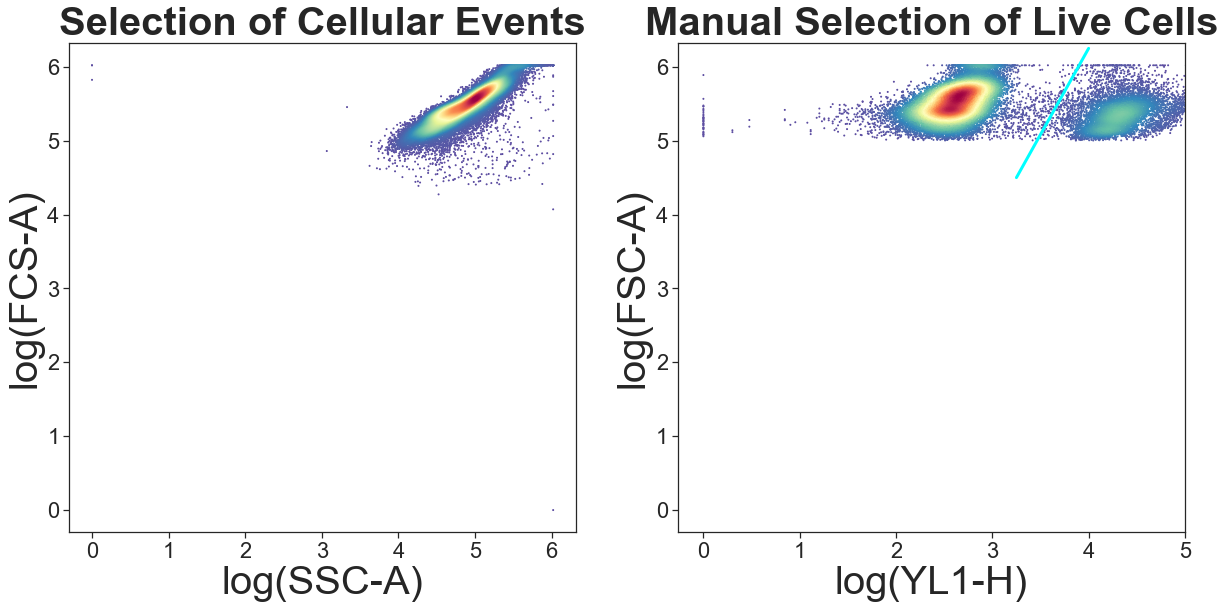

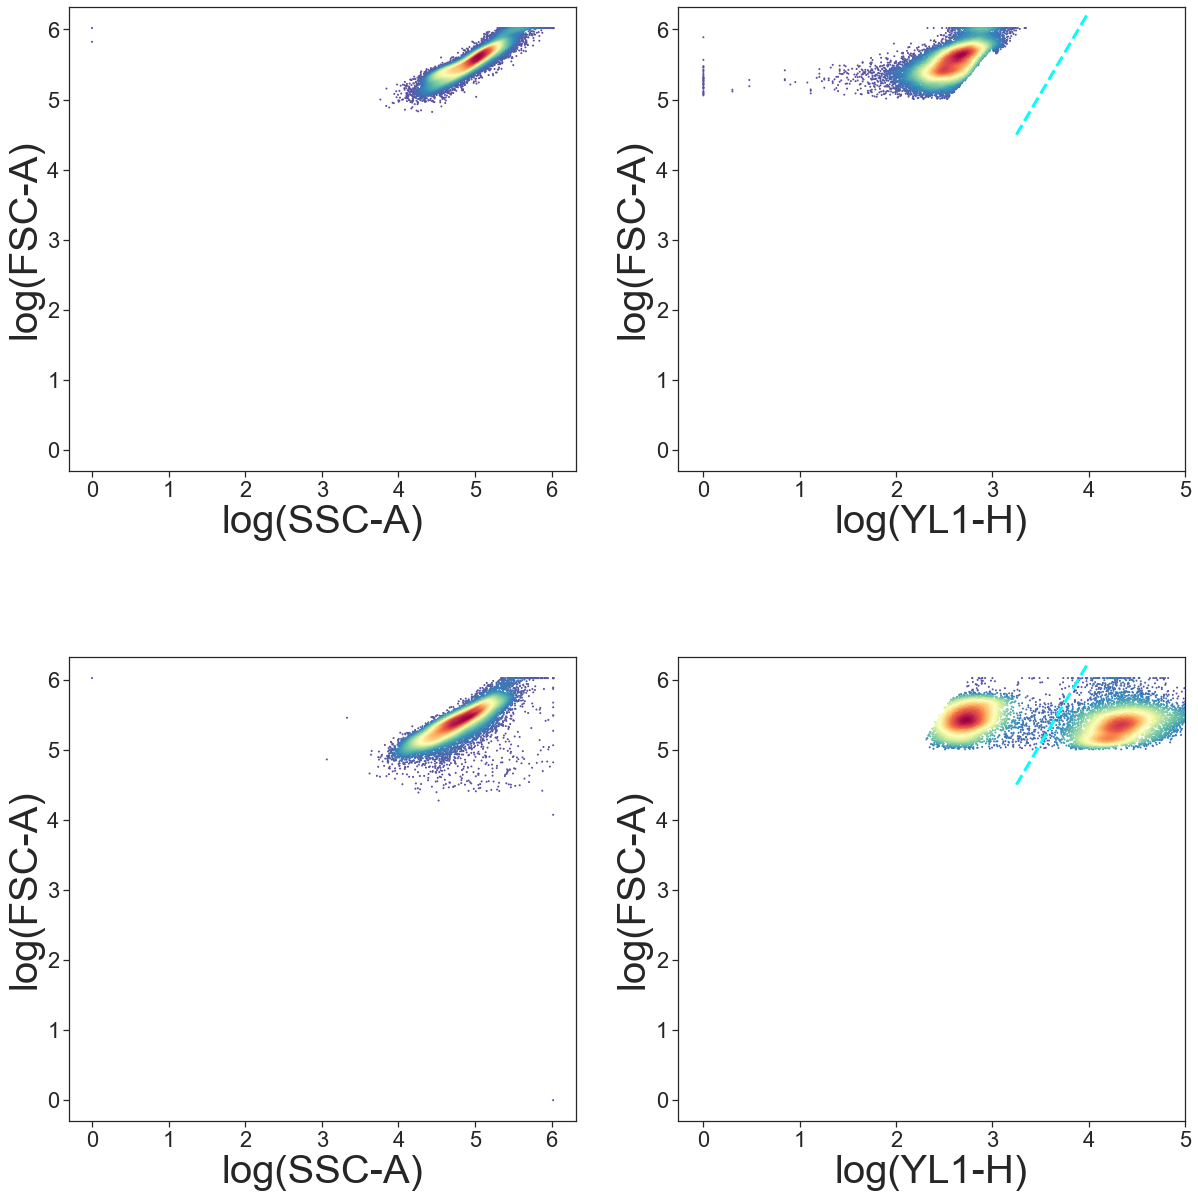

In [14]:
final_df = kde_scatter(kde_df, cc="{}-H".format(color_channel_to_use), logged=True,
                       fraction_of_points_based_on_kde=0.9,
                       point_1_that_defines_line=point_1_that_defines_soa_line, 
                       point_2_that_defines_line=point_2_that_defines_soa_line,
                       cmap="Spectral_r", pred_col="nn_preds")

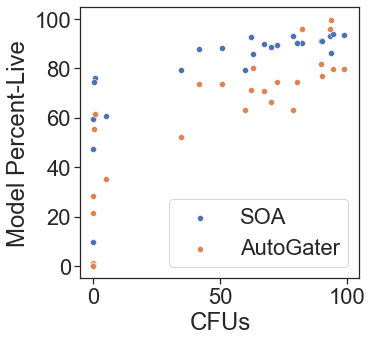

R-Squared between CFUs and State-of-the-Art predicted Percent-Live: 0.06
R-Squared between CFUs and AutoGater predicted Percent-Live: 0.55
R-Squared between CFUs and RFC predicted Percent-Live: 0.4



In [15]:
summary_table = summary_table_of_results(final_df)

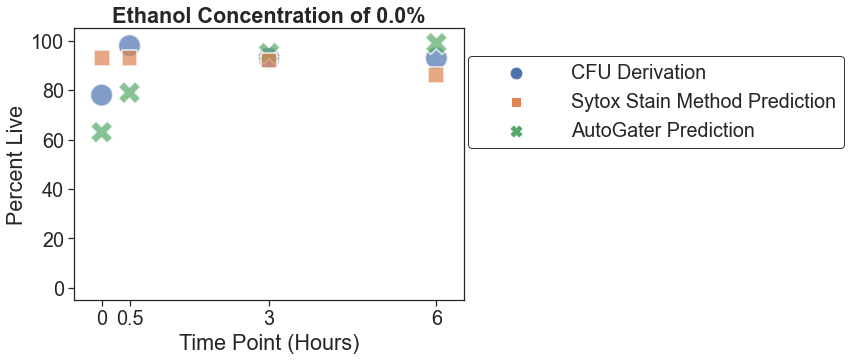

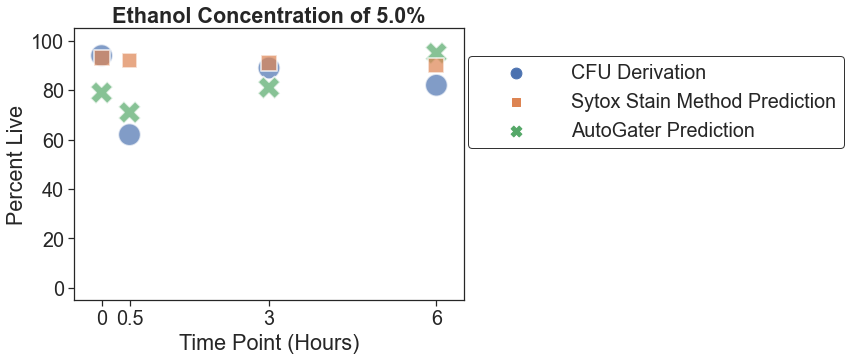

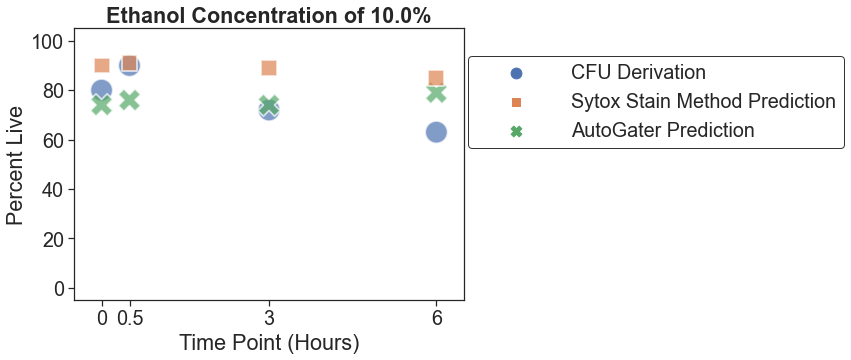

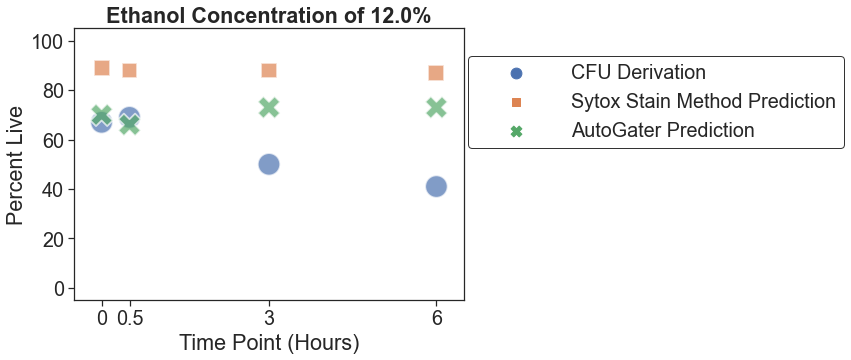

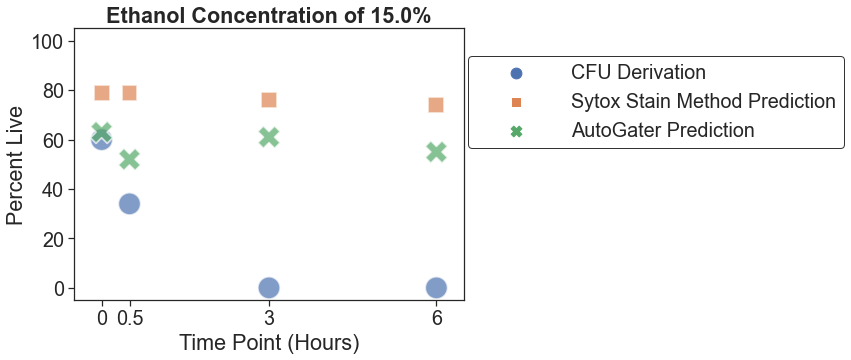

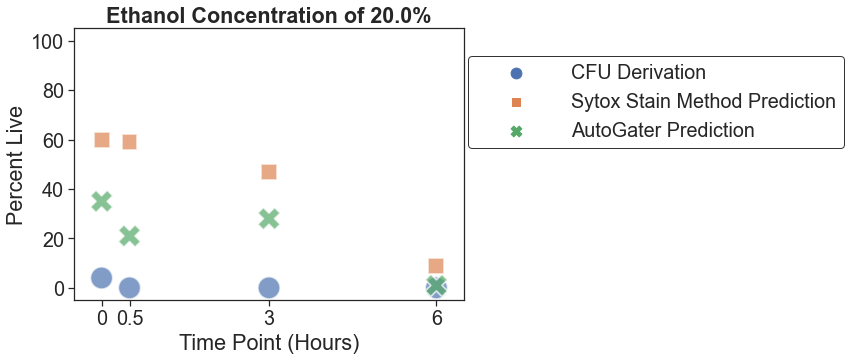

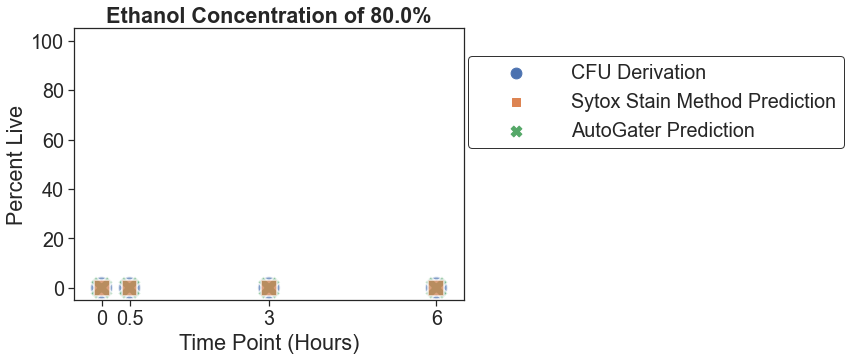

In [16]:
percent_live_comparison_plot(summary_table)